# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

In [1]:
from unityagents import UnityEnvironment
import numpy as np

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher.app')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128,
                 fc2_units=128):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fc1_units: int. Number of nodes in first hidden layer
        :param fc2_units: int. Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # source: The low-dimensional networks had 2 hidden layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        # source: The final layer weights and biases of the actor and were
        # initialized from a uniform distribution [−3 × 10−3, 3 × 10−3]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        # source: used the rectified non-linearity for all hidden layers
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        # source The final output layer of the actor was a tanh layer,
        # to bound the actions
        return torch.tanh(self.fc3(x))
    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128,
                 fc2_units=128):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fcs1_units: int. Nb of nodes in the first hiddenlayer
        :param fc2_units: int. Nb of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        # source: The final layer weights and biases of the critic were
        # initialized from a uniform distribution [3 × 10−4, 3 × 10−4]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        # source: Actions were not included until the 2nd hidden layer of Q
        x = torch.cat((xs, action.float()), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.hard_copy_weights(self.actor_target, self.actor_local)
        self.hard_copy_weights(self.critic_target, self.critic_local)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

In [11]:
def ddpg(n_episodes=1000, max_t=10000, print_every=100):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    scores_deque = deque(maxlen=print_every)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_deque.append(score)       # save most recent score
        scores.append(score)             # save most recent score

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [12]:
scores = ddpg(n_episodes = 500)


Episode 1	Score: 0.76	Average Score: 0.76
Episode 1	Average Score: 0.76
Episode 2	Score: 0.37	Average Score: 0.56
Episode 2	Average Score: 0.56
Episode 3	Score: 0.35	Average Score: 0.49
Episode 3	Average Score: 0.49
Episode 4	Score: 0.47	Average Score: 0.49
Episode 4	Average Score: 0.49
Episode 5	Score: 0.76	Average Score: 0.54
Episode 5	Average Score: 0.54
Episode 6	Score: 0.53	Average Score: 0.54
Episode 6	Average Score: 0.54
Episode 7	Score: 0.67	Average Score: 0.56
Episode 7	Average Score: 0.56
Episode 8	Score: 0.89	Average Score: 0.60
Episode 8	Average Score: 0.60
Episode 9	Score: 0.95	Average Score: 0.64
Episode 9	Average Score: 0.64
Episode 10	Score: 0.17	Average Score: 0.59
Episode 10	Average Score: 0.59
Episode 11	Score: 0.58	Average Score: 0.59
Episode 11	Average Score: 0.59
Episode 12	Score: 0.35	Average Score: 0.57
Episode 12	Average Score: 0.57
Episode 13	Score: 1.27	Average Score: 0.62
Episode 13	Average Score: 0.62
Episode 14	Score: 0.34	Average Score: 0.60
Episode 14	Av

Episode 112	Score: 5.90	Average Score: 4.41
Episode 112	Average Score: 4.41
Episode 113	Score: 7.83	Average Score: 4.47
Episode 113	Average Score: 4.47
Episode 114	Score: 7.49	Average Score: 4.54
Episode 114	Average Score: 4.54
Episode 115	Score: 9.61	Average Score: 4.63
Episode 115	Average Score: 4.63
Episode 116	Score: 7.63	Average Score: 4.70
Episode 116	Average Score: 4.70
Episode 117	Score: 8.79	Average Score: 4.77
Episode 117	Average Score: 4.77
Episode 118	Score: 11.15	Average Score: 4.87
Episode 118	Average Score: 4.87
Episode 119	Score: 9.61	Average Score: 4.93
Episode 119	Average Score: 4.93
Episode 120	Score: 9.79	Average Score: 5.01
Episode 120	Average Score: 5.01
Episode 121	Score: 9.17	Average Score: 5.10
Episode 121	Average Score: 5.10
Episode 122	Score: 11.91	Average Score: 5.22
Episode 122	Average Score: 5.22
Episode 123	Score: 3.50	Average Score: 5.25
Episode 123	Average Score: 5.25
Episode 124	Score: 8.05	Average Score: 5.32
Episode 124	Average Score: 5.32
Episode 12

Episode 218	Score: 39.63	Average Score: 19.89
Episode 218	Average Score: 19.89
Episode 219	Score: 39.30	Average Score: 20.18
Episode 219	Average Score: 20.18
Episode 220	Score: 34.66	Average Score: 20.43
Episode 220	Average Score: 20.43
Episode 221	Score: 39.60	Average Score: 20.74
Episode 221	Average Score: 20.74
Episode 222	Score: 36.35	Average Score: 20.98
Episode 222	Average Score: 20.98
Episode 223	Score: 23.32	Average Score: 21.18
Episode 223	Average Score: 21.18
Episode 224	Score: 38.56	Average Score: 21.48
Episode 224	Average Score: 21.48
Episode 225	Score: 34.59	Average Score: 21.72
Episode 225	Average Score: 21.72
Episode 226	Score: 35.18	Average Score: 21.92
Episode 226	Average Score: 21.92
Episode 227	Score: 26.19	Average Score: 22.11
Episode 227	Average Score: 22.11
Episode 228	Score: 14.33	Average Score: 22.04
Episode 228	Average Score: 22.04
Episode 229	Score: 34.13	Average Score: 22.28
Episode 229	Average Score: 22.28
Episode 230	Score: 12.91	Average Score: 22.32
Episod

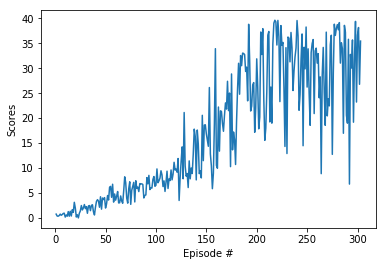

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()